<a href="https://colab.research.google.com/github/florencia-cicarone/tp3-HPC/blob/main/Cuaderno_2_%20Martes_%20grupo2_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introducción

En este cuaderno ...
    

# 2. Armado del ambiente


Escribir

## 2.1 Módulo CUDA

Se instala en el cuaderno el módulo CUDA de python.

In [30]:
!pip install pycuda

# 3. Desarrollo CPU

Ejecución del algoritmo adición de dos imágenes en CPU.





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/matplotlib/ticker.py:2161: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


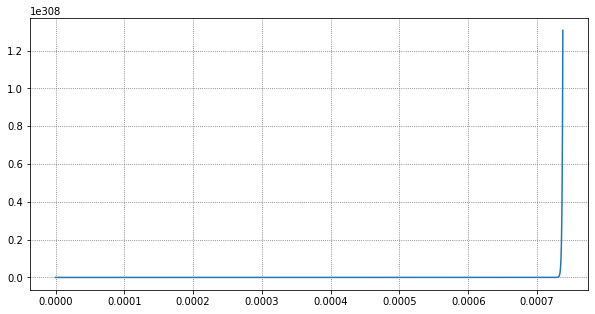

Tiempo Total:  6065.152 [ms]
Tiempo bucle:  5549.1720000000005 [ms]


In [100]:
#@title 3.1 Parámetros de ejecución { vertical-output: true }

cantidad_N =    10000000#@param {type: "number"}


from datetime import datetime
tiempo_total = datetime.now()

import numpy
import matplotlib.pyplot as plt 
import math

tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

try:
  x = numpy.linspace(0, 5, cantidad_N) 
except ValueError:
  sys.exit("La cantidad N no puede ser menor a 0")
y = numpy.zeros_like(x)


tiempo_bucle = datetime.now()
y[0]=1
y[1]=1
for key in range(2, cantidad_N):
  y[key] = y[key-1]+y[key-2]
tiempo_bucle = datetime.now() - tiempo_bucle

fig = plt.figure(figsize = (10, 5)) 
# Create the plot 
plt.plot(x, y)

plt.grid(b=True, which='major', color='#666666', linestyle='dotted')
  
# Show the plot 
plt.show() 

# -------------------------------------------

tiempo_total = datetime.now() - tiempo_total

print("Tiempo Total: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo bucle: ", tiempo_en_ms( tiempo_bucle ), "[ms]" )

# 4. Desarrollo GPU

Ejecución del algoritmo adición de dos imágenes en GPU.


In [94]:
%matplotlib inline
// Falta implementar

SyntaxError: ignored

# 5. Métricas

Comparativa de las velocidades entre CPU y GPU


|                                   | CPU            | GPU           |
|-----------------------------------|----------------|---------------|
|**Tiempo de conversión de imagen:**| 14447.602 [ms] | 0.196 [ms]    |
|**Tiempo TOTAL:**                  | 14550.574 [ms] | 113.482 [ms]  |


# 6. Conclusiones

# 7. Bibliografía



*   https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb
*   http://dis.um.es/~ginesgm/files/doc/pi/tema2.pdf

